# **Stirred (not shaken)**

What can we learn about a system if we inject a tracer and measure the outlet concentration as a function of time?

**MOD510: Project 3**

Date: **November 4th 2025**

Names: **Malvin Varpe & Torgrim Odde**

**Learning obectives:** By completing this project, the student will:
* Implement an ODE solver using Euler,  Runge-Kutta (second fourth order) algorithm
* Use mixing tank models to model how the shape of a medical tracer changes after traveling in an aorta arch
* Compare the ODE model to CDF simulation results and extract information about the cardiac output (flooding rate) and volume of the aortic arch
* Investigate if one can use the tracer signal to identify if there is an aneurysm in the aorta

**Abstract:**

**Introduction:**


# Exercise 1 - Write your own ODE solver
**Part 1**
Implement an ODE solver, that solves an arbitrary (initial value) system of ODEs of the form

$$\frac{d\vec{y}}{dt} = \vec{f}(\vec{y}, t) (4)$$

where the solution $\vec{y}$ may be a vector. Since the equation system is completely generic, the solver has to take in as argument the function that computes the right hand side-vector; that is, you are not allowed to hard-code in a specific model.
In addition, the solver needs to know the starting time, $t_0$, the corresponding initial condition(s) $\vec{f}(\vec{y}, t)$, as well as the final simulation time, $t_f$.
The user should be able to choose between the following methods:
1. Eulers method
2. Runge-Kutta second order (RK2)
3. Runge-Kutta fourth order (RK4)

Tip: It can be a good idea to encapsulate your solver inside a custom class, and to implement one class function for each method.

In [4]:
import numpy as np

# Implementing solvers

class ODESolver:
    def __init__(self, f):
        self.f = f  # f(y, t) -> dy/dt as np.array

    def _step_euler(self, y, t, h): # Simple Euler solution
        return y + h * self.f(y, t)

    def _step_rk2(self, y, t, h): # R2K solution
        k1 = self.f(y, t)
        k2 = self.f(y + h*k1, t + h)
        return y + 0.5*h*(k1 + k2)

    def _step_rk4(self, y, t, h): # R4K solution
        k1 = self.f(y, t)
        k2 = self.f(y + 0.5*h*k1, t + 0.5*h)
        k3 = self.f(y + 0.5*h*k2, t + 0.5*h)
        k4 = self.f(y + h*k3, t + h)
        return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    def solve(self, y0, tspan, h, method="rk4"):
        steppers = {
            "euler": self._step_euler, 
            "rk2": self._step_rk2, 
            "rk4": self._step_rk4
        }
        
        step = steppers[method.lower()]
        t0, tf = tspan
        N = int(np.ceil((tf - t0)/h)) + 1
        t = np.linspace(t0, tf, N)
        y = np.empty((N, len(np.atleast_1d(y0))), dtype=float)
        y[0] = y0
        for i in range(N-1):
            h_i = t[i+1]-t[i]
            y[i+1] = step(y[i], t[i], h_i)
        return t, y


In [10]:
# We can build the RHS for any n by integrating C over C(0) = 0 for chosen Euler/R2K/R4K solution

def rhs_tanks(n, tau):
    k = n / tau
    def f(C, t):
        dC = np.zeros_like(C)
        dC[0] = -k * C[0]                  # dC0/dt = (n/tau)*(0 - C0)
        for i in range(1, n):
            dC[i] = k * (C[i - 1] - C[i])  # dCi/dt = (n/tau)*(C_{i-1} - Ci)
        return dC
    return f


**Part 2:**

Test your implementation against the analytical solutions in equation (3) for n = 1, 2 and 3.
* for n = 1 use $\tau$ = 2, C0(0) = 1
* for n = 2 use $\tau$ = 2, C0(0) = 1, C1(0) = 0
* for n = 3 use $\tau$ = 2, C0(0) = 1, C1(0) = C2(0) = 0

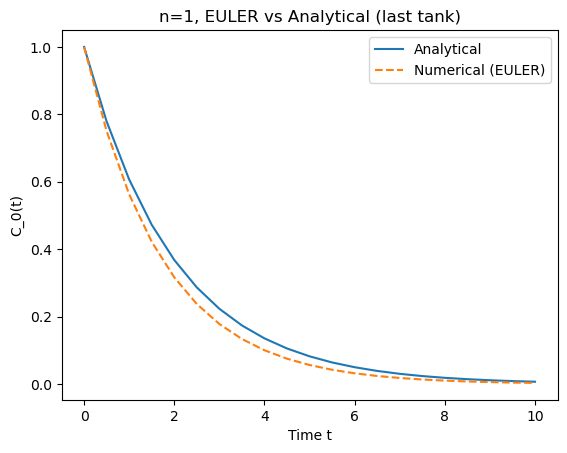

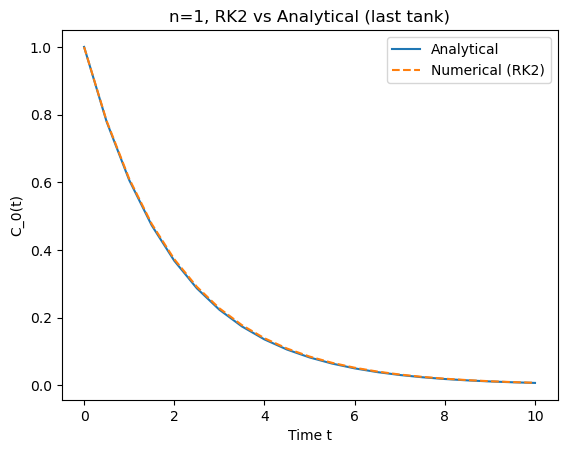

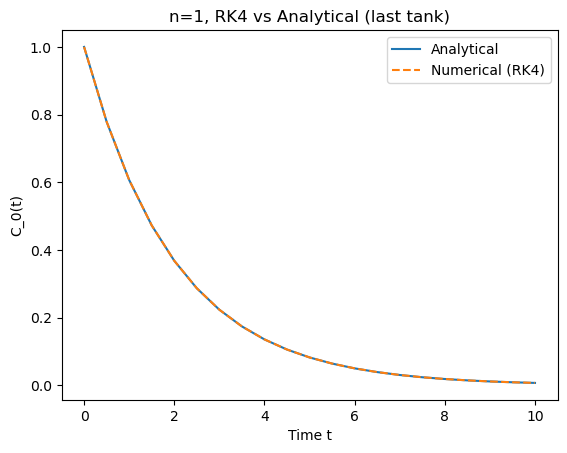

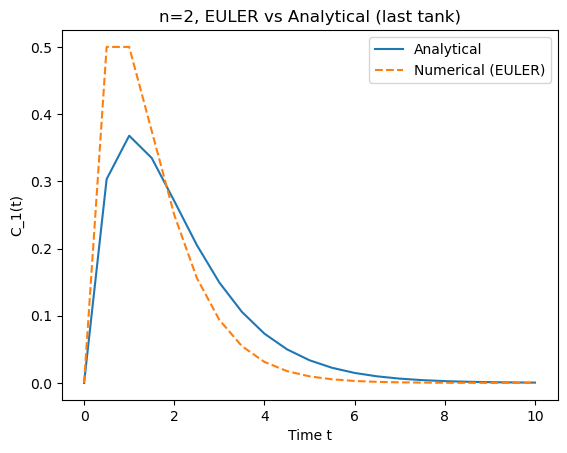

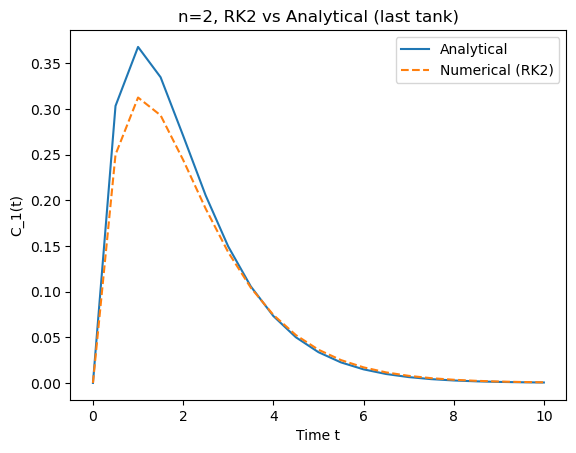

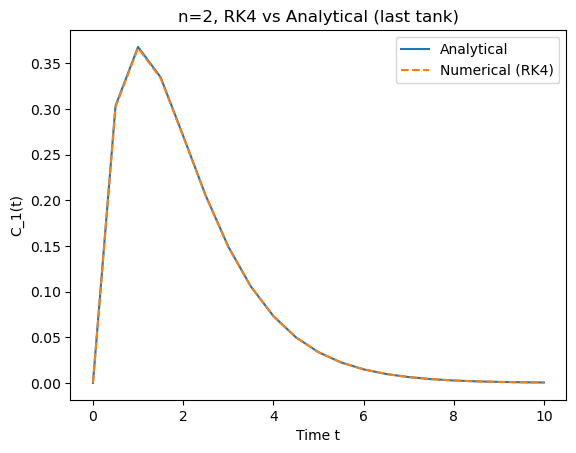

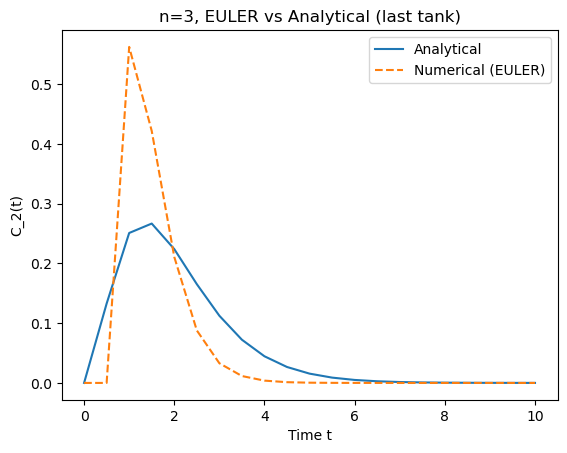

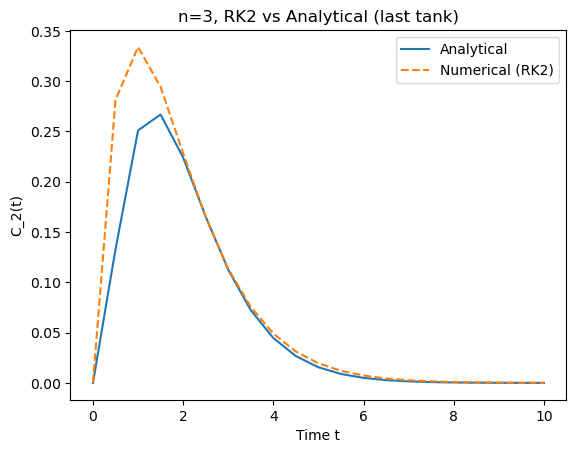

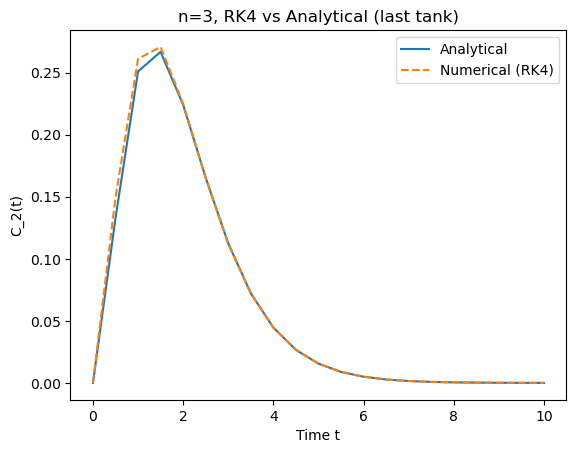

 n method  step_size_h  max_abs_error  L2_error
 1  EULER          0.5       0.051473  0.095718
 1    RK2          0.5       0.004650  0.008951
 1    RK4          0.5       0.000015  0.000028
 2  EULER          0.5       0.196735  0.187414
 2    RK2          0.5       0.055379  0.065702
 2    RK4          0.5       0.001289  0.001585
 3  EULER          0.5       0.311479  0.280680
 3    RK2          0.5       0.148397  0.121980
 3    RK4          0.5       0.016561  0.014043


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def analytical_last_tank(n, t, tau):
    """
    Special ICs: C0(0)=1, others 0. (matches the problem statement)
      n=1: C0(t) = exp(-t/tau)
      n=2: C1(t) = (2t/tau) * exp(-2t/tau)
      n=3: C2(t) = (9 t^2 / (2 tau^2)) * exp(-3t/tau)
    """
    if n == 1:
        return np.exp(-t / tau)
    elif n == 2:
        return (2.0 * t / tau) * np.exp(-2.0 * t / tau)
    elif n == 3:
        return (9.0 * (t ** 2) / (2.0 * (tau ** 2))) * np.exp(-3.0 * t / tau)
    else:
        raise ValueError("Analytical expression implemented only for n in {1, 2, 3}.")

# Validation & plotting

tau = 2.0
t0, tf = 0.0, 10.0         # simulate long enough to see decay
h = 0.5                  # step size (can be adjusted to test convergence)
                            #using large h to clearly show solver differences
methods = ["euler", "rk2", "rk4"]

records = []               # for error table

for n in [1, 2, 3]:
    # Initial conditions:
    # n=1: C0(0)=1 -> Exponential decau
    # n=2: C0(0)=1, C1(0)=0 -> peak then decay
    # n=3: C0(0)=1, C1(0)=C2(0)=0 -> Lower peak, broader decay
    C_init = np.zeros(n)
    C_init[0] = 1.0

    f = rhs_tanks(n, tau)
    solver = ODESolver(f)

    for method in methods:
        t, C = solver.solve(C_init, (t0, tf), h, method=method)
        num_last = C[:, -1]
        exact_last = analytical_last_tank(n, t, tau)

        # Plot numerical vs analytical for this case
        plt.figure()
        plt.plot(t, exact_last, label="Analytical")
        plt.plot(t, num_last, linestyle="--", label=f"Numerical ({method.upper()})")
        plt.title(f"n={n}, {method.upper()} vs Analytical (last tank)")
        plt.xlabel("Time t")
        plt.ylabel(f"C_{n-1}(t)")
        plt.legend()
        plt.show()

        # Errors
        max_abs_err = float(np.max(np.abs(num_last - exact_last)))
        l2_err = float(np.sqrt(np.trapz((num_last - exact_last) ** 2, t)))
        records.append({
            "n": n,
            "method": method.upper(),
            "step_size_h": h,
            "max_abs_error": max_abs_err,
            "L2_error": l2_err
        })

# Printing error table
df_errors = pd.DataFrame.from_records(records).sort_values(["n", "method"])
print(df_errors.to_string(index=False))

From the plots we can see that with a low step size **h**, the three solvers perform differently for all values of **n**.
The Euler, which is first order, has the largest error of the three and we can see a clear difference between the numerical and analytical solution.
The R2K, being second order, performs better, but still with slight errors.
The R4K, being 4th order, outperforms the two other solvers by far and the numerical solution is almost identical to the analytical solution.

This is also represented in the error table, showing how the R4K outperforms the other solvers by a relative large margin, while the Euler has the largest error.

We can reduce the timestep **h** in order to improve performance and reduce the difference between the numerical and analytical solutions for all solvers.

**Part 3:** 

Pick n =1, 2, or 3
1. plot the numerical error at t = 1, for the last tank, and for dt values in
the range 0.1, . . . 0.001. (You may try lower values if you have a very fast
solver)
2. does the numerical error scale as expected for Euler, RK2, and RK4?

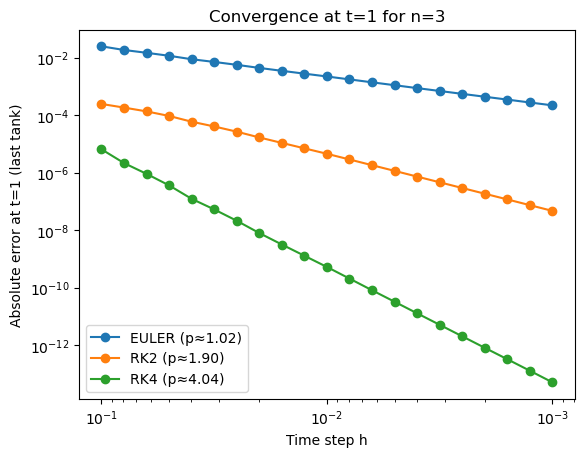

,h,err_EULER,err_RK2,err_RK4
0,0.100000,0.024875,2.457382e-04,6.517022e-06
1,0.079433,0.018560,1.839495e-04,2.159572e-06
2,0.063096,0.014804,1.356097e-04,9.091404e-07
3,0.050119,0.011659,9.401510e-05,3.613335e-07
4,0.039811,0.008842,5.928391e-05,1.230298e-07
5,0.031623,0.007121,4.055454e-05,5.268685e-08
6,0.025119,0.005655,2.670709e-05,2.125489e-08
7,0.019953,0.004407,1.681274e-05,7.937976e-09
8,0.015849,0.003495,1.085072e-05,3.169912e-09
9,0.012589,0.002786,7.029967e-06,1.288515e-09


Observed orders (slope on log-log error vs h):
  EULER: p ≈ 1.017
  RK2: p ≈ 1.901
  RK4: p ≈ 4.037


In [23]:
n_choice = 3
tau = 2.0
t_final = 1.0
dt_vals = np.logspace(-1, -3, 21)  # 0.1 ... 0.001
methods = ["euler", "rk2", "rk4"]

errors = {m: [] for m in methods}

for h in dt_vals:
    C0 = np.zeros(n_choice); C0[0] = 1.0
    f = rhs_tanks(n_choice, tau)
    solver = ODESolver(f)
    for m in methods:
        t, C = solver.solve(C0, (0.0, t_final), h, method=m)
        num = C[-1, -1]
        exact = analytical_last_tank(n_choice, t[-1], tau)
        errors[m].append(abs(num - exact))

def observed_order(hs, errs, floor=1e-15):
    hs = np.array(hs)
    errs = np.maximum(np.array(errs), floor)
    mask = errs > 1e-12
    if np.sum(mask) >= 2:
        x = np.log(hs[mask])
        y = np.log(errs[mask])
        p = np.polyfit(x, y, 1)[0]
        return p
    return np.nan

orders = {m: observed_order(dt_vals, errors[m]) for m in methods}

plt.figure()
for m in methods:
    plt.loglog(dt_vals, errors[m], marker="o", label=f"{m.upper()} (p≈{orders[m]:.2f})")
plt.gca().invert_xaxis()
plt.xlabel("Time step h")
plt.ylabel("Absolute error at t=1 (last tank)")
plt.title(f"Convergence at t=1 for n={n_choice}")
plt.legend()
plt.show()

rows = []
for i, h in enumerate(dt_vals):
    row = {"h": h}
    for m in methods:
        row[f"err_{m.upper()}"] = errors[m][i]
    rows.append(row)

df = pd.DataFrame(rows)
display(df)

print("Observed orders (slope on log-log error vs h):")
for m in methods:
    print(f"  {m.upper()}: p ≈ {orders[m]:.3f}")

From the convergence plot, we see the errors of the Euler, R2K and R4K solvers on a log-log scale. The Euler slope ~1, meaning that if we halve **h**, the error is reduced by ~half. The R2K slope is ~2, meaning that if we halve **h**, the error is reduced by ~4x. The R4K slope is ~4, meaning that if we **halve** h, the error is reduced by ~16x. Each curve shows a smooth line since the error scales with $error(h) ∝ h^p$ (where p= 1 for Euler, 2 for R2K and 4 for R4K).

The table shows how as the step size **h** gets smaller, the error in each column decreases. We see that Euler has consistently the largest error, whilst the R4K error becomes tiny even for moderate values of **h**. All numerical errors scale as expected.